## DA-VINCIS 2023: Detection of Aggressive and Violent Incidents from Social Media in Spanish

# Binary Classification (Task 1)

In [ ]:
! pip install transformers
! pip install --quiet "torchvision" "torch>==1.10" 
! pip install --quiet "pytorch-lightning>=2.0.0" "typing-extensions>=4.0.0" "typing-extensions>=4.2.0" "torchmetrics>=0.3" 
! pip install --quiet "tf-estimator-nightly" "folium==0.9.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gc
import re
import torch
import os
import torch.optim
import time
import datetime
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import  BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import confusion_matrix
from torchmetrics import Accuracy 
from torchmetrics import F1Score 

In [ ]:
run_on = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(run_on)
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Colab Notebooks/DAVINCI-2023/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dfTexts = pd.read_csv(PATH + 'train/train_data.csv', names=['description'],header=None)
dfLabels = pd.read_table(PATH + 'train/train_labels_subtask_1.csv', names=['Incident'],header=None)

dictionary = {'Category':dfLabels['Incident'].values, 'Text':dfTexts['description'].values}
df = pd.DataFrame(data=dictionary)

pd.set_option('display.max_colwidth',None)
df.head(5)

,Category,Text
0,0,Morales: #EEUU “sufrió una derrota vergonzosa” ante el terrorismo y el narcotráfico #NarcoterrorismoDoméstico https://t.co/GCenoztH3H https://t.co/WMF36c68i3
1,0,"Tus acciones te hacen ser una bella persona, no tu color de piel o tu dinero, esa joven con su hermoso gesto me robo el corazon. https://t.co/wXfw2Hrqv7"
2,1,"#Seguridad 🚨🛑 Detuvo policía municipal a dos hombres por robo a casa habitación, en #Puebla. En la acción se recuperaron computadoras portátiles, un equipo de audio, un dispositivo de comunicación móvil, entre otros artículos. Urbano| Noticias https://t.co/xXKSnVjz8k... https://t.co/HcoPbEpPLk"
3,0,20 años del accidente que convirtió a Alex Zanardi en leyenda. https://t.co/TALvr20hB5
4,0,"¡Llega el castigo para Max Verstappen! El neerlandés tendrá tres posiciones de sanción en la parrilla de salida del #RussianGP, tras el accidente que protagonizó con Lewis Hamilton en el #ItalianGP ¿Qué opinan de la decisión de la FIA? | #F1 https://t.co/yfUlLPzcGL"


[]

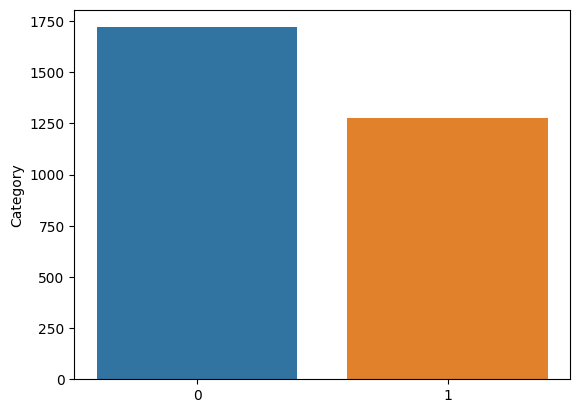

In [ ]:
#class distribution
counts = df['Category'].value_counts()
ax = sns.barplot(x=df['Category'].unique(), y=counts)
ax.plot()

In [ ]:
# Extract the columns from the dataframe
features = df['Text']
labels = df['Category']

X_train, X_val, y_train, y_val = train_test_split(features, labels)

# Partition sizes
print('Number of training set samples : {}'.format(len(X_train)))
print('Number of validation set samples : {}'.format(len(X_val)))

Number of training set samples : 2247
Number of validation set samples : 749


In [ ]:
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []

    for doc in dataset:
      encoded_doc = tokenizer.encode_plus(doc,
                                          add_special_tokens=True,
                                          max_length=128,
                                          truncation=True,
                                          padding="max_length")
        
      input_ids.append(encoded_doc['input_ids'])
      attention_mask.append(encoded_doc['attention_mask'])

    return (torch.tensor(input_ids), torch.tensor(attention_mask))

# Tokenize training and validation partitions
X_train_inputs, X_train_masks = preprocessing(X_train)
X_val_inputs, X_val_masks = preprocessing(X_val)

# Calculate the maximum number of words per message 
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Maximum number of tokens in training messages {0}'.format(max_len))

Maximum number of tokens in training messages 128


In [ ]:
# Data loaders
batch_size = 32

y_train_labels = torch.tensor(y_train.values)
y_val_labels = torch.tensor(y_val.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler,
                 batch_size=batch_size,
                 num_workers=0)
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks,
                   y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, 
                 y_val_labels)

In [ ]:
# set random seed
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed_all(value)
set_seed(42)

In [ ]:
# Create model and optimizer. Set BETO parameters to perform fine tuning
model = BertForSequenceClassification.from_pretrained(
        "dccuchile/bert-base-spanish-wwm-cased",
         num_labels=2,
         output_attentions=False,
         output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr = 4e-5,
                  eps = 1e-6
                  )

if run_on == 'cuda':
    model.cuda()

# Define number of epochs
epochs = 5

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
            num_warmup_steps = 0, 
            num_training_steps = total_steps)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [ ]:
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#variable to plot the confusion matrix
conf = []

In [ ]:
#training and validation function for each epoch
def training(n_epochs, training_dataloader,
             validation_dataloader):
  
    print('======= Training =======')

    max_step_t = len(training_dataloader)
    max_step_v = len(validation_dataloader)
    acc=F1Score('binary')

    for epoch_i in range(0,n_epochs):
        # for each epoch...
        print("")
        print('======= Epoch {:} / {:} ======='.format(
             epoch_i + 1, epochs))
        # We save the start time to see how long it takes.
        t0 = time.time()
        # We reset the loss value for each epoch.
        total_loss = 0
        # We put the model in training mode.
        model.train()

        # For each subset (minibatch) of the training set:
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # We disarm the dataloader in:
             # [0]: input ids (indexes in the BETO token dictionary),
             # [1]: attention masks (how much attention is given to each token in the sentence),
             # [2]: labels (the result that should be returned: the data y)
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # We clean the gradients for the present batch
            model.zero_grad()

            # Propagation forward in the layers
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # We calculate the loss of the present minibatch
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Backpropagation
            loss.backward()

            #(this prevents the gradient from becoming explosive)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # We update the parameters
            optimizer.step()
            scheduler.step()
            if step %50 == 0 or step==max_step_t:
              print('Nº Batch: {0}/{1} | batch loss: {2} | avg loss: {3}'.format(step, max_step_t, batch_loss, total_loss/(step+1)))
        # We calculate the average loss in the current epoch of the training set
        avg_train_loss = total_loss / len(train_dataloader)

        print("  Average training loss: {0:.2f}".
             format(avg_train_loss))
        print("  Training epoch took: {:}".format(
              format_time(time.time() - t0)))

        print("======= Validation =======")

        t0 = time.time()

        # We put the model in validation mode
        model.eval()

        # We declare variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []

        # We evaluate the data by minibatches
        for step, batch in enumerate(validation_dataloader):

            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # We don't want the model to compute gradients
            with torch.no_grad():
                # We generate the predictions of the model
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            # ...we extract them
            logits = outputs[0]

            # We move the logits (data prior to the activation function) to the CPU
            logits = logits.detach().cpu()
            b_labels = b_labels.to('cpu')

            # Guardamos los logits y las etiquetas
            # They will be useful for the confusion matrix.
            predict_labels = np.argmax(
                             logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # We calculate the accuracy of this batch
            tmp_eval_accuracy = (predict_labels == b_labels).sum()/predict_labels.shape[0]

            # We calculate the cumulative accuracy up to the current epoch.
            eval_accuracy += tmp_eval_accuracy

        # We show the final accuracy for this epoch
        print("  Accuracy: {0:.2f}".
              format(eval_accuracy / (step+1)))
        print("  Validation took: {:}".format(
             format_time(time.time() - t0)))

    # We show the confusion matrix
    conf = confusion_matrix(
           all_labels, all_logits, normalize='true')
    print("Training complete")
    return conf

In [ ]:
conf = training(epochs, train_dataloader, val_dataloader)

======= Training =======

======= Epoch 1 / 5 =======
Nº Batch: 0/71 | batch loss: 0.7438700795173645 | avg loss: 0.7438700795173645
Nº Batch: 50/71 | batch loss: 0.27001693844795227 | avg loss: 0.34665998933362024
  Average training loss: 0.32
  Training epoch took: 0:00:47
======= Validation =======
  Accuracy: 0.93
  Validation took: 0:00:05

======= Epoch 2 / 5 =======
Nº Batch: 0/71 | batch loss: 0.22119969129562378 | avg loss: 0.22119969129562378
Nº Batch: 50/71 | batch loss: 0.1529303640127182 | avg loss: 0.14045794176704743
  Average training loss: 0.13
  Training epoch took: 0:00:44
======= Validation =======
  Accuracy: 0.93
  Validation took: 0:00:05

======= Epoch 3 / 5 =======
Nº Batch: 0/71 | batch loss: 0.10883229225873947 | avg loss: 0.10883229225873947
Nº Batch: 50/71 | batch loss: 0.1603672206401825 | avg loss: 0.06915436737586324
  Average training loss: 0.06
  Training epoch took: 0:00:45
======= Validation =======
  Accuracy: 0.93
  Validation took: 0:00:05

======

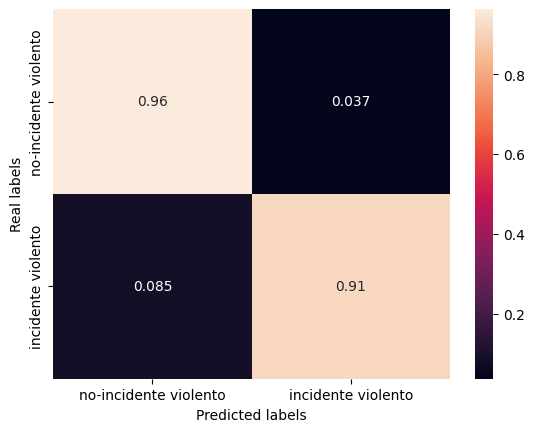

In [ ]:
ticks = ['no-incidente violento', 'incidente violento']
ax = sns.heatmap(conf, annot=True, xticklabels=ticks, yticklabels=ticks)
ax.set(xlabel='Predicted labels', ylabel='Real labels')
plt.show()

In [ ]:
#validation partition for evaluate BETO model
def classify_incident(message):
  encoding_txt = tokenizer.encode_plus(
      message,
      max_length = 128,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      padding="max_length",
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  
  input_ids = encoding_txt['input_ids'].to(device)
  attention_mask = encoding_txt['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output.logits, dim=1)
  
  return prediction.item()

In [ ]:
#dfTestTexts = pd.read_csv(PATH + 'train1/validation_data.csv',names=['description'],header=None)
dfTestTexts = pd.read_csv(PATH + 'train/test_data.csv',names=['description'],header=None)

pd.set_option('display.max_colwidth',None)
dfTestTexts.head(5)

,description
"['E_hBbp6XMAknEbw.jpg', 'E_hBbNiXMAITzrB.jpg', 'E_hBaxeXMAM58cB.jpg']",En el sector Los Hongos de Tunja se presentó un accidente de tránsito. @bomberostunja atendió la emergencia. https://t.co/617qGVw8BP
['E_KhOU6XIAc0mQ0.jpg'],"#TráficoSv | Reportan un accidente de tránsito en los alrededores de la zona industrial en la carretera Panamericana, en el sentido que de Santa Ana conduce hacia San Salvador. https://t.co/RDBA4L4poe"
['E_QPcM4XIAAaxM6.jpg'],"#13Sep #Lara Vehículo impacta contra una tubería de agua Pasadas las horas del medio día de este lunes, se registró un accidente en la carretera Centroccidental a la altura del sector Santana, del municipio Torres en Lara. Según la información aportada… https://t.co/bwZ86hCMXJ https://t.co/MvJgoKOwP3"
['E_LLYrEXEAUqner.jpg'],"@PNCSV confirma Accidente de tránsito en carretera Troncal del Norte a la altura del kilómetro 5 1/2, provocado por una rastra, que al parecer perdió el control, impactando contra una gasolinera. El hecho dejó dos fallecidos, un hombre y una mujer que p"
"['E_SRMtcXoAA_CPz.jpg', 'E_SRMXDXIAE0ZZJ.jpg']","Unidades del BCBVP atendieron emergencia por accidente de tránsito en la Avenida Pastrana, en donde una persona del sexo masculino que se movilizaba como conductor de una motocicleta, colisionó con otro velomotor lo que le ocasionó trauma en la extremidad superior derecha. https://t.co/tvYo3yAEqZ"


In [ ]:
y_test_hat = []

for index, row in dfTestTexts.iterrows():
    y_test_hat.append(classify_incident(row["description"]))

In [ ]:
result=pd.DataFrame(list(map(np.ravel, y_test_hat)),columns=['incidents'])
result

,incidents
0,1
1,1
2,1
3,1
4,1
...,...
1148,1
1149,0
1150,0
1151,1


In [ ]:
from google.colab import files
result.to_csv('TXT_result.csv', index=False, header=None)
!zip -r '/content/TXT_Task1.zip' 'TXT_result.csv'
files.download('/content/TXT_Task1.zip')
#resulting zip file in the corresponding site for subtask1

updating: TXT_result.csv (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Multilabel classification (Task 2)

In [ ]:
#if a model is alredy in gpu
model.cpu()
del model

In [ ]:
#clean the cache of the previous model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
dfTexts = pd.read_csv(PATH + 'train/train_data.csv',names=['description'],header=None)
dfLabels = pd.read_table(PATH + 'train/train_labels_subtask_2.csv', delimiter=',',header=None)

d = {'Categories':dfLabels.values.tolist(), 'Text':dfTexts['description'].values}
df = pd.DataFrame(data=d)

pd.set_option('display.max_colwidth',None)
df.head(5)

,Categories,Text
0,"[0, 0, 0, 1]",Morales: #EEUU “sufrió una derrota vergonzosa” ante el terrorismo y el narcotráfico #NarcoterrorismoDoméstico https://t.co/GCenoztH3H https://t.co/WMF36c68i3
1,"[0, 0, 0, 1]","Tus acciones te hacen ser una bella persona, no tu color de piel o tu dinero, esa joven con su hermoso gesto me robo el corazon. https://t.co/wXfw2Hrqv7"
2,"[0, 0, 1, 0]","#Seguridad 🚨🛑 Detuvo policía municipal a dos hombres por robo a casa habitación, en #Puebla. En la acción se recuperaron computadoras portátiles, un equipo de audio, un dispositivo de comunicación móvil, entre otros artículos. Urbano| Noticias https://t.co/xXKSnVjz8k... https://t.co/HcoPbEpPLk"
3,"[0, 0, 0, 1]",20 años del accidente que convirtió a Alex Zanardi en leyenda. https://t.co/TALvr20hB5
4,"[0, 0, 0, 1]","¡Llega el castigo para Max Verstappen! El neerlandés tendrá tres posiciones de sanción en la parrilla de salida del #RussianGP, tras el accidente que protagonizó con Lewis Hamilton en el #ItalianGP ¿Qué opinan de la decisión de la FIA? | #F1 https://t.co/yfUlLPzcGL"


[]

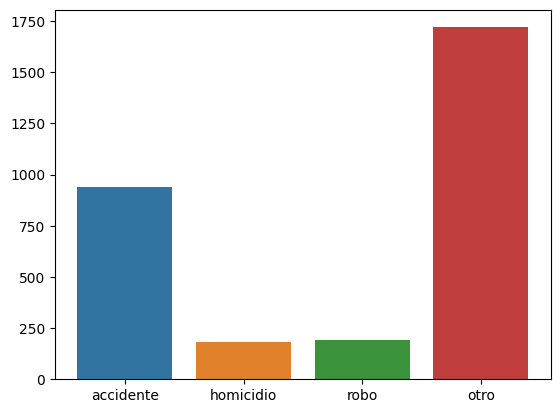

In [ ]:
#class distribution
categories = df['Categories']
counts=[categories.apply(lambda x: x[i]).sum() for i in range(4)]
x=['accidente','homicidio','robo','otro']
ax = sns.barplot(x=x, y=counts)
ax.plot()

In [ ]:
# Extract the columns from the dataframe
features = df['Text']
labels = df['Categories']

X_train, X_val, y_train, y_val = train_test_split(features, labels)

# Partition sizes
print('Number of training set samples : {}'.format(len(X_train)))
print('Number of validation set samples : {}'.format(len(X_val)))

Number of training set samples : 2247
Number of validation set samples : 749


In [ ]:
#Tokenization
#Transforming the words of the messages into features expected by BETO with maximum size of a message to 128 tokens
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []

    for doc in dataset:
      encoded_doc = tokenizer.encode_plus(doc,
                                          add_special_tokens=True,
                                          max_length=128,
                                          truncation=True,
                                          padding="max_length")
        
      input_ids.append(encoded_doc['input_ids'])
      attention_mask.append(encoded_doc['attention_mask'])

    return (torch.tensor(input_ids), torch.tensor(attention_mask))

# We tokenize training and validation partitions
X_train_inputs, X_train_masks = preprocessing(X_train)
X_val_inputs, X_val_masks = preprocessing(X_val)

# We calculate the maximum number of words per message 
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Maximum number of tokens in training messages {0}'.format(max_len))

Maximum number of tokens in training messages 128


In [ ]:
# Data loaders
batch_size = 32

y_train_labels = torch.stack([torch.tensor(lista) for lista in y_train.values]).to(torch.float)
y_val_labels = torch.stack([torch.tensor(lista) for lista in y_val.values]).to(torch.float)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler,
                 batch_size=batch_size,
                 num_workers=0)
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks,
                   y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, 
                 y_val_labels)

In [ ]:
# set random seed
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed_all(value)
set_seed(42)

In [ ]:
# Create model and optimizer
model = BertForSequenceClassification.from_pretrained(
        "dccuchile/bert-base-spanish-wwm-cased",
         num_labels=4,
         output_attentions=False,
         output_hidden_states=False)

optimizer = AdamW(model.parameters(),
                  lr = 4e-5,
                  eps = 1e-6
                  )

if run_on == 'cuda':
    model.cuda()

# Define number of epochs
epochs = 5

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
            num_warmup_steps = 0, 
            num_training_steps = total_steps)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [ ]:
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#variable to plot the confusion matrix
conf = []

In [ ]:
def training(n_epochs, training_dataloader,
             validation_dataloader):
    print('======= Training =======')

    max_step_t = len(training_dataloader)
    max_step_v = len(validation_dataloader)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    acc=Accuracy(average='macro', task="multiclass", num_classes=4, mdmc_average='samplewise')

    for epoch_i in range(0,n_epochs):
        print("")
        print('======= Epoch {:} / {:} ======='.format(
             epoch_i + 1, epochs))
        t0 = time.time()
        total_loss = 0
        model.train()
        
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            model.zero_grad()

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            )

            loss = loss_fn(outputs[0], b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

            optimizer.step()
            scheduler.step()
            if step %50 == 0 or step==max_step_t:
              print('Nº Batch: {0}/{1} | batch loss: {2} | avg loss: {3}'.format(step, max_step_t, batch_loss, total_loss/(step+1)))

        avg_train_loss = total_loss / len(train_dataloader)

        print("")
        print("  Average training loss: {0:.2f}".
             format(avg_train_loss))
        print("  Training epoch took: {:}".format(
              format_time(time.time() - t0)))

        print("======= Validation =======")

        t0 = time.time()

        model.eval()

        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        total=0.
        correct = 0.

        for step, batch in enumerate(validation_dataloader):

            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            with torch.no_grad():
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            logits = outputs[0]

            logits = logits.detach().cpu()
            b_labels = b_labels.int().to('cpu')

            predict_labels = torch.round(torch.sigmoid(logits)).int()

            tmp_eval_accuracy = sum([torch.equal(predict_labels[i],b_labels[i]) for i in range(b_labels.shape[0])])/b_labels.shape[0]

            eval_accuracy += tmp_eval_accuracy

        print("  Accuracy: {0:.2f}".
              format(eval_accuracy / (step+1)))
        print("  Validation took: {:}".format(
             format_time(time.time() - t0)))

    print("Training complete")

In [ ]:
conf = training(epochs, train_dataloader, val_dataloader)

======= Training =======

======= Epoch 1 / 5 =======
Nº Batch: 0/71 | batch loss: 0.7041471004486084 | avg loss: 0.7041471004486084
Nº Batch: 50/71 | batch loss: 0.18274745345115662 | avg loss: 0.28486033324517457

  Average training loss: 0.24
  Training epoch took: 0:00:45
======= Validation =======
  Accuracy: 0.89
  Validation took: 0:00:05

======= Epoch 2 / 5 =======
Nº Batch: 0/71 | batch loss: 0.11673637479543686 | avg loss: 0.11673637479543686
Nº Batch: 50/71 | batch loss: 0.08918208628892899 | avg loss: 0.09467754275629334

  Average training loss: 0.08
  Training epoch took: 0:00:45
======= Validation =======
  Accuracy: 0.92
  Validation took: 0:00:05

======= Epoch 3 / 5 =======
Nº Batch: 0/71 | batch loss: 0.02364243194460869 | avg loss: 0.02364243194460869
Nº Batch: 50/71 | batch loss: 0.023399565368890762 | avg loss: 0.04772289086352376

  Average training loss: 0.04
  Training epoch took: 0:00:45
======= Validation =======
  Accuracy: 0.92
  Validation took: 0:00:05



In [ ]:
#Predictions on evaluation set
def classify_incident(message):
  encoding_txt = tokenizer.encode_plus(
      message,
      max_length = 128,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      padding="max_length",
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  model.eval()
  with torch.no_grad():
    input_ids = encoding_txt['input_ids'].to(device)
    attention_mask = encoding_txt['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
  
  return np.round(torch.sigmoid(output[0]).cpu().numpy())[0].astype(int)

In [ ]:
#dfTestTexts = pd.read_csv(PATH + 'train/validation_data.csv', header=None, names=['description'])
dfTestTexts = pd.read_csv(PATH + 'train/test_data.csv', header=None, names=['description'])
pd.set_option('display.max_colwidth',None)
dfTestTexts.head(5)

,description
"['E_hBbp6XMAknEbw.jpg', 'E_hBbNiXMAITzrB.jpg', 'E_hBaxeXMAM58cB.jpg']",En el sector Los Hongos de Tunja se presentó un accidente de tránsito. @bomberostunja atendió la emergencia. https://t.co/617qGVw8BP
['E_KhOU6XIAc0mQ0.jpg'],"#TráficoSv | Reportan un accidente de tránsito en los alrededores de la zona industrial en la carretera Panamericana, en el sentido que de Santa Ana conduce hacia San Salvador. https://t.co/RDBA4L4poe"
['E_QPcM4XIAAaxM6.jpg'],"#13Sep #Lara Vehículo impacta contra una tubería de agua Pasadas las horas del medio día de este lunes, se registró un accidente en la carretera Centroccidental a la altura del sector Santana, del municipio Torres en Lara. Según la información aportada… https://t.co/bwZ86hCMXJ https://t.co/MvJgoKOwP3"
['E_LLYrEXEAUqner.jpg'],"@PNCSV confirma Accidente de tránsito en carretera Troncal del Norte a la altura del kilómetro 5 1/2, provocado por una rastra, que al parecer perdió el control, impactando contra una gasolinera. El hecho dejó dos fallecidos, un hombre y una mujer que p"
"['E_SRMtcXoAA_CPz.jpg', 'E_SRMXDXIAE0ZZJ.jpg']","Unidades del BCBVP atendieron emergencia por accidente de tránsito en la Avenida Pastrana, en donde una persona del sexo masculino que se movilizaba como conductor de una motocicleta, colisionó con otro velomotor lo que le ocasionó trauma en la extremidad superior derecha. https://t.co/tvYo3yAEqZ"


In [ ]:
y_test_hat = []

for index, row in dfTestTexts.iterrows():
    y_test_hat.append(classify_incident(row["description"]))

In [ ]:
#['accident', 'murder', 'robbery', 'other']
result=pd.DataFrame(list(map(np.ravel, y_test_hat)),columns=['accidente','homicidio','robo','otro'])
result

,accidente,homicidio,robo,otro
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
1148,1,0,0,0
1149,0,0,0,1
1150,0,0,0,1
1151,1,0,0,0


In [ ]:
from google.colab import files
result.to_csv('TXT_result2.csv', index=False, header=None)
!zip -r '/content/TXT_Task2.zip' 'TXT_result2.csv'
files.download('/content/TXT_Task2.zip') 

updating: TXT_result2.csv (deflated 94%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>